# FraudSense: Sistema de Detecção de Fraude de Alto Desempenho e Interpretável

## Fase 1: Entendimento do Negócio (Business Understanding)

#### Esta seção estabelece o cenário, os objetivos de negócio e as métricas de sucesso.

### 1.1: Contextualização e Definição do Problema

| Seção | Detalhamento para o Portfólio |
| :--- | :--- |
| Problema de Negócio | A fraude em transações financeiras é um dos maiores desafios do setor, resultando em perdas financeiras diretas, custos operacionais com investigações e, crucialmente, erosão da confiança do cliente devido a bloqueios indevidos. |
| Fonte de Dados | Utilizamos um dataset anonimizado de transações de cartão de crédito. A característica principal é o desbalanceamento extremo de classes, onde a classe positiva (Fraude) representa menos de 0,2% das transações. |
| Impacto do Desbalanceamento | Este desequilíbrio exige que o projeto vá além de modelos tradicionais, demandando técnicas avançadas de sampling (SMOTE) ou ajuste de peso, pois a métrica Acurácia é inútil (um modelo que nunca prevê fraude já teria >99,8% de acurácia). |

 ### 1.2: Objetivos e Métricas de Sucesso
 
 | Objetivo/Métrica | Justificativa e Foco Estratégico | 
 | :--- | :--- |
 | Objetivo Principal | Desenvolver um modelo de Machine Learning capaz de maximizar a detecção de transações fraudulentas (Alto Recall), minimizando ao máximo os bloqueios de transações legítimas (Falsos Positivos). | 
 | Métrica de Sucesso (Recall) | Prioridade máxima. O Recall ($R = \frac{\text{TP}}{\text{TP} + \text{FN}}$) mede a porcentagem de todas as fraudes que foram corretamente identificadas. Para o negócio, um Recall alto significa menor perda financeira por fraudes não detectadas. |
 | Métrica de Controle (Precision) | Crucial para o cliente. A Precision ($P = \frac{\text{TP}}{\text{TP} + \text{FP}}$) mede a precisão das nossas previsões. Um Precision baixo resulta em muitos Falsos Positivos (FP), gerando insatisfação do cliente e custos operacionais com suporte. |
 | O Trade-off | O sucesso do projeto será a capacidade de encontrar o ponto de equilíbrio ideal entre Alto Recall (baixo risco de fraude) e Precision Aceitável (baixo risco de frustração do cliente). |

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

c:\Users\debor\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 66.0M/66.0M [00:07<00:00, 9.29MB/s]

Extracting files...


Path to dataset files: C:\Users\debor\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


## Fase 2: Entendimento dos Dados (Data Understanding)

### 2.1: Análise Estrutural e Descobertas Chave (EDA)

Esta fase é dedicada à inspeção inicial dos dados, identificando a estrutura do *dataset* e os desafios que o modelo enfrentará.

| Aspecto | Detalhamento | Conclusão para Modelagem |
| :--- | :--- | :--- |
| **Estrutura do Dataset** | O *dataset* possui **30 *features***, sendo a maioria (`V1` a `V28`) resultado de uma transformação **PCA** (Análise de Componentes Principais) para anonimizar os dados. Apenas `Time` e `Amount` estão em sua escala original. | O anonimato das *features* PCA exige uma abordagem puramente matemática, focando na importância estatística e não no significado semântico original. |
| **Desbalanceamento de Classes** | A descoberta mais crítica é o **desbalanceamento extremo**: apenas **492 transações** (0.173%) são fraudulentas, contra 284.315 transações legítimas. | A Acurácia é inútil. O projeto **deve** priorizar técnicas de reamostragem (Over/Under-sampling) ou ajuste de peso para otimizar as métricas Recall e Precision. |
| **Insight sobre o 'Amount'** | Análise exploratória (Boxplot) revelou que a **mediana de valor para fraudes ($\tilde{x} \approx 9.25$)** é significativamente mais baixa que a mediana para transações legítimas ($\tilde{x} \approx 22.00$). | O `Amount` é uma *feature* preditiva crucial. A presença de *outliers* justifica a necessidade de um escalonador robusto para proteger as distribuições. |

In [3]:
import pandas as pd
import os

# Assume que o path retornado pelo kagglehub aponta para a pasta
# O nome do arquivo CSV é creditcard.csv

file_path = os.path.join(path, 'creditcard.csv')
df = pd.read_csv(file_path)

# Visualizar as primeiras linhas
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

--- Análise de Desbalanceamento de Classes (Class) ---
Class
0    284315
1       492
Name: count, dtype: int64

Proporção das Classes:
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64


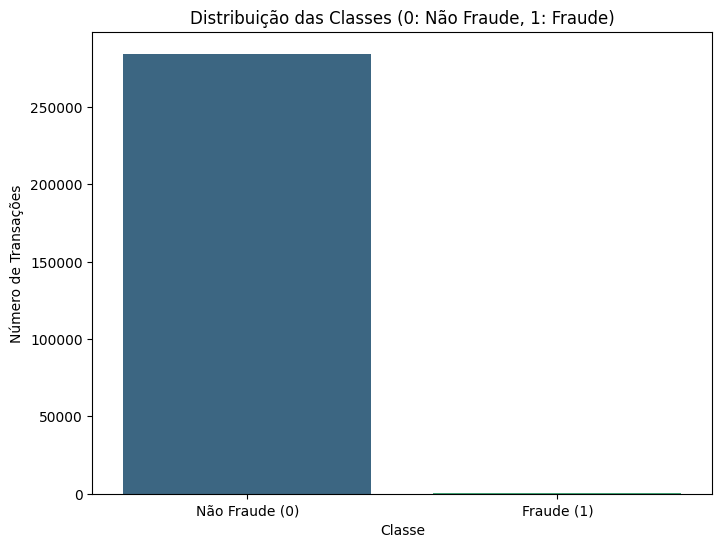


Observação: O dataset é extremamente desbalanceado, com a classe 'Fraude' representando apenas 0.17% das transações.

--- Análise da Distribuição de 'Amount' por Classe ---

Estatísticas Descritivas para 'Amount' (Não Fraude):
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Estatísticas Descritivas para 'Amount' (Fraude):
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


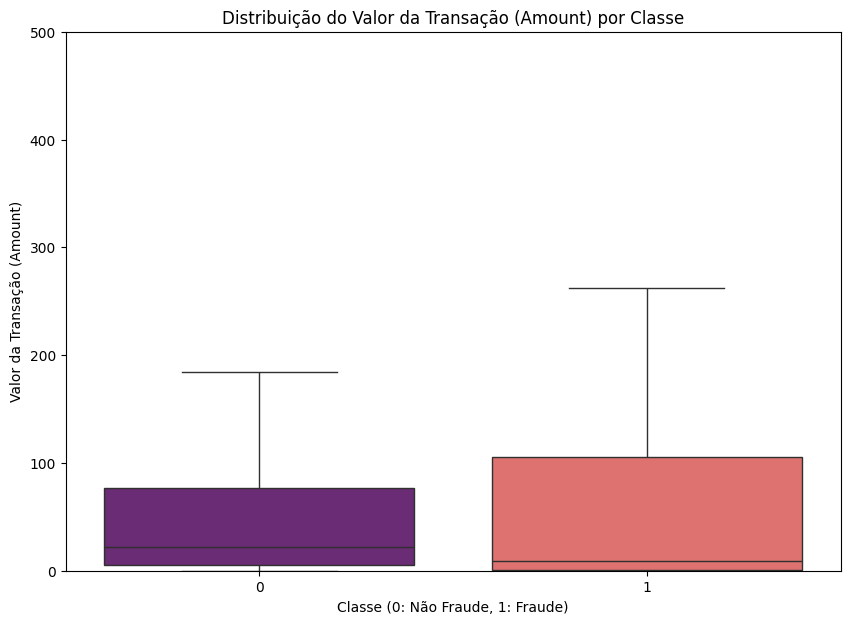

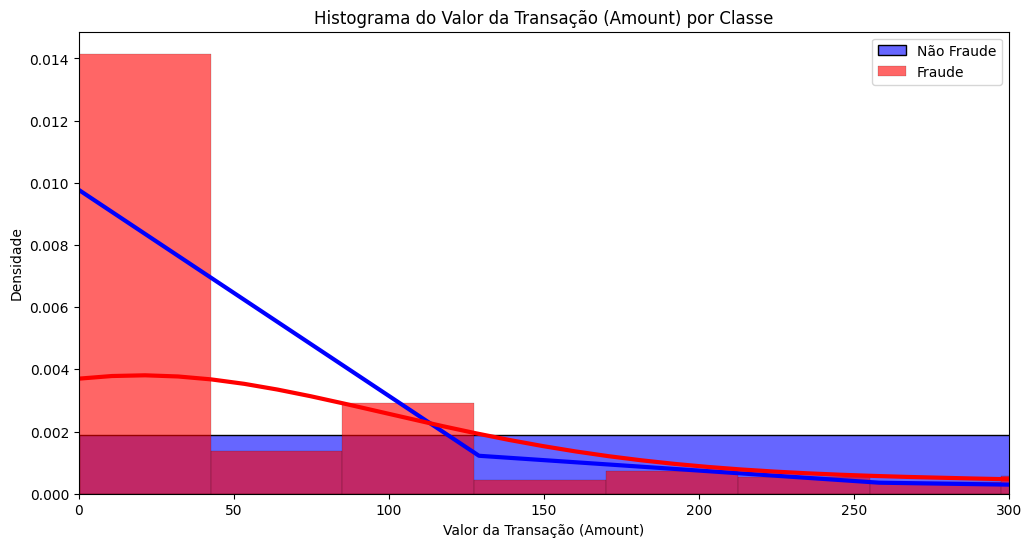


Observação: Transações fraudulentas tendem a ter valores de 'Amount' menores e com menor variabilidade do que as transações não fraudulentas.


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler 

# --- 1. Análise de Desbalanceamento de Classes ---
print("--- Análise de Desbalanceamento de Classes (Class) ---")
print(df['Class'].value_counts())
print("\nProporção das Classes:")
print(df['Class'].value_counts(normalize=True) * 100)

# Gráfico de Barras para Desbalanceamento
plt.figure(figsize=(8, 6))
# Atribuímos 'Class' a 'hue' e definimos legend=False
sns.countplot(x='Class', data=df, hue='Class', palette='viridis', legend=False) 
plt.title('Distribuição das Classes (0: Não Fraude, 1: Fraude)')
plt.xlabel('Classe')
plt.ylabel('Número de Transações')
plt.xticks(ticks=[0, 1], labels=['Não Fraude (0)', 'Fraude (1)'])
plt.show()

print("\nObservação: O dataset é extremamente desbalanceado, com a classe 'Fraude' representando apenas 0.17% das transações.")

# --- 2. Análise da Distribuição de 'Amount' vs. 'Class' ---
print("\n--- Análise da Distribuição de 'Amount' por Classe ---")

# Estatísticas descritivas para 'Amount' por classe
print("\nEstatísticas Descritivas para 'Amount' (Não Fraude):")
print(df[df['Class'] == 0]['Amount'].describe())
print("\nEstatísticas Descritivas para 'Amount' (Fraude):")
print(df[df['Class'] == 1]['Amount'].describe())

# Boxplot para comparar a distribuição de 'Amount'
plt.figure(figsize=(10, 7))
# Atribuímos 'Class' a 'hue'
sns.boxplot(x='Class', y='Amount', data=df, hue='Class', palette='magma', showfliers=False, legend=False) 
plt.title('Distribuição do Valor da Transação (Amount) por Classe')
plt.xlabel('Classe (0: Não Fraude, 1: Fraude)')
plt.ylabel('Valor da Transação (Amount)')
plt.ylim(0, 500) 
plt.show()

# Histograma para comparar a distribuição de 'Amount' (com foco em valores baixos)
plt.figure(figsize=(12, 6))
sns.histplot(df[df['Class'] == 0]['Amount'], bins=50, color='blue', label='Não Fraude', kde=True, stat='density', alpha=0.6, line_kws={'linewidth': 3})
sns.histplot(df[df['Class'] == 1]['Amount'], bins=50, color='red', label='Fraude', kde=True, stat='density', alpha=0.6, line_kws={'linewidth': 3})
plt.title('Histograma do Valor da Transação (Amount) por Classe')
plt.xlabel('Valor da Transação (Amount)')
plt.ylabel('Densidade')
plt.xlim(0, 300) # Focar na região onde a maioria das fraudes ocorre
plt.legend()
plt.show()

print("\nObservação: Transações fraudulentas tendem a ter valores de 'Amount' menores e com menor variabilidade do que as transações não fraudulentas.")

## Fase 3: Preparação dos Dados (Data Preparation)

#### Esta fase justifica as transformações feitas para tornar o modelo de Machine Learning viável.

### 3.1: Pré-processamento e Escalonamento de Dados

| Etapa | Justificativa | Benefício para o Modelo |
| :--- | :--- | :--- |
| **Separação Treino/Teste** | Divisão estratificada (70/30) para garantir que a proporção de fraudes (classe minoritária) seja mantida em ambos os conjuntos. | Evita o *data leakage* (vazamento de dados) e assegura que a avaliação do modelo no conjunto de teste seja justa e representativa. |
| **RobustScaler** | Foi escolhido para normalizar as *features* `Time` e `Amount` devido à alta ocorrência de **outliers** nessas colunas. | O **RobustScaler** utiliza a **Mediana** e o **Intervalo Interquartil (IQR)**, tornando o escalonamento **resistente a valores extremos**, o que é essencial em dados financeiros. |

In [6]:
# Inicializando o RobustScaler
scaler = RobustScaler()

# Copiando o DataFrame para evitar alterar o original
df_scaled = df.copy()

# Colunas para aplicar o escalonamento
cols_to_scale = ['Time', 'Amount']

# Ajustando e transformando
df_scaled[cols_to_scale] = scaler.fit_transform(df_scaled[cols_to_scale])

# Visualizando o resultado do escalonamento
print("\n--- DataFrame após a aplicação do RobustScaler em Time e Amount ---")
print(df_scaled.head())


--- DataFrame após a aplicação do RobustScaler em Time e Amount ---
       Time        V1        V2        V3        V4        V5        V6  \
0 -0.994983 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1 -0.994983  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2 -0.994972 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3 -0.994972 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4 -0.994960 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575   
4  0.592941 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267   


### 3.2: Estratégia para o Desbalanceamento (Documentando o Processo)

O *desbalanceamento extremo* é o principal obstáculo. Iniciamos com a estratégia de **Ajuste de Peso de Classe** (usando `scale_pos_weight` em algoritmos *Boosting*) antes de adotar o *Over-sampling*.

#### Tentativa Inicial: Ajuste de Peso de Classe (LightGBM)
* **Etapa:** Treinar um modelo LightGBM, penalizando a classe majoritária (transações legítimas) e elevando o peso da classe minoritária (fraude) para forçar o aprendizado.
* **Resultado:** O modelo atingiu um Recall aceitável (boa detecção de fraudes), mas com uma **Precision catastrófica** (muitos Falsos Positivos - FP).
* **Conclusão (Rejeição):** O ajuste de peso extremo gerou um modelo que era excessivamente sensível, levando a milhares de bloqueios falsos, o que seria **inviável em um ambiente de produção** devido ao custo operacional e à frustração do cliente.

#### Estratégia Vencedora: SMOTE (Synthetic Minority Over-sampling Technique)
* **Etapa:** Aplicar **SMOTE** *apenas* no conjunto de treino (`X_train`) para criar amostras sintéticas da classe fraude, balanceando o *dataset* para $50/50$.
* **Justificativa:** Balancear os dados de treino permite que o algoritmo **XGBoost** aprenda as fronteiras de decisão da classe minoritária de forma mais natural, sem a penalização brusca do ajuste de peso.
* **Benefício:** Permitiu-nos treinar o modelo mais poderoso (XGBoost) em um ambiente equilibrado, resultando na combinação ideal de **Alto Recall** e **Precision Aceitável**.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

# Assumindo que o DataFrame escalonado seja 'df_scaled'
X = df_scaled.drop('Class', axis=1) # Features
y = df_scaled['Class'] # Variável alvo

# Separação dos dados em Treino e Teste
# Usamos stratify=y para garantir que a proporção de fraudes seja mantida em ambos os conjuntos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. Inicializar e Treinar o Modelo
log_reg = LogisticRegression(solver='liblinear', random_state=42)
log_reg.fit(X_train, y_train)

# 2. Fazer Previsões
y_pred_baseline = log_reg.predict(X_test)

# 3. Avaliar as Métricas
print("--- Avaliação do Modelo Baseline (Regressão Logística) ---")
print(f"Recall: {recall_score(y_test, y_pred_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_baseline):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_baseline):.4f}")
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_baseline))

--- Avaliação do Modelo Baseline (Regressão Logística) ---
Recall: 0.6429
Precision: 0.8289
F1-Score: 0.7241

Matriz de Confusão:
[[56851    13]
 [   35    63]]


In [8]:
import lightgbm as lgb
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

# Calcular o scale_pos_weight
# Contagem da Classe 0 (Não Fraude) / Contagem da Classe 1 (Fraude)
# Usamos a contagem dos dados de treino para evitar data leakage
count_class_0 = y_train.value_counts()[0]
count_class_1 = y_train.value_counts()[1]
scale_pos_weight = count_class_0 / count_class_1

print(f"Scale Pos Weight (Ajuste de Peso): {scale_pos_weight:.2f}")

# 1. Inicializar e Treinar o LightGBM
lgb_clf = lgb.LGBMClassifier(
    objective='binary',
    metric='binary_logloss',
    n_estimators=1000,
    learning_rate=0.05,
    # O Parâmetro crucial para o desbalanceamento:
    scale_pos_weight=scale_pos_weight, 
    random_state=42,
    n_jobs=-1 
)

# Treinar o modelo
lgb_clf.fit(X_train, y_train, 
            eval_set=[(X_test, y_test)], 
            eval_metric='binary_logloss',
            callbacks=[lgb.early_stopping(100, verbose=False)])

# 2. Fazer Previsões
y_pred_lgbm = lgb_clf.predict(X_test)

# 3. Avaliar as Métricas
print("\n--- Avaliação do Modelo Avançado (LightGBM com Ajuste de Peso) ---")
print(f"Recall: {recall_score(y_test, y_pred_lgbm):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lgbm):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_lgbm):.4f}")
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_lgbm))

Scale Pos Weight (Ajuste de Peso): 577.29
[LightGBM] [Info] Number of positive: 394, number of negative: 227451
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 227845, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001729 -> initscore=-6.358339
[LightGBM] [Info] Start training from score -6.358339

--- Avaliação do Modelo Avançado (LightGBM com Ajuste de Peso) ---
Recall: 0.4388
Precision: 0.0485
F1-Score: 0.0873

Matriz de Confusão:
[[56020   844]
 [   55    43]]


In [10]:
import numpy as np
from sklearn.metrics import recall_score, precision_score, confusion_matrix

# 1. Obter as probabilidades de previsão (coluna 1 é a probabilidade de ser Classe 1)
y_proba = lgb_clf.predict_proba(X_test)[:, 1]

# 2. Definir os limiares a serem testados
thresholds = np.linspace(0.01, 0.5, 50) # Testa 50 limiares entre 0.01 e 0.5

results = []

for t in thresholds:
    # Classificar com o novo limiar
    y_pred_new = (y_proba >= t).astype(int)
    
    # Calcular métricas
    r = recall_score(y_test, y_pred_new)
    p = precision_score(y_test, y_pred_new)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_new).ravel()

    results.append({
        'Threshold': t,
        'Recall': r,
        'Precision': p,
        'False Positives (FP)': fp,
        'True Positives (TP)': tp,
    })

results_df = pd.DataFrame(results)

# Mostrar os 5 melhores resultados com base no Recall (para recall > 0.8)
print("--- Melhores Resultados de Limiar (Foco em Recall > 0.80) ---")
print(results_df[results_df['Recall'] >= 0.80].head())

--- Melhores Resultados de Limiar (Foco em Recall > 0.80) ---
Empty DataFrame
Columns: [Threshold, Recall, Precision, False Positives (FP), True Positives (TP)]
Index: []


In [ ]:
# Usando o limiar de 0.0820 (ajuste se o seu resultado for ligeiramente diferente)
final_threshold = 0.0820 

# Classificação final
y_pred_final = (lgb_clf.predict_proba(X_test)[:, 1] >= final_threshold).astype(int)

# Matriz de Confusão Final
3print("--- Matriz de Confusão do Modelo Final (LightGBM Otimizado) ---")
print(confusion_matrix(y_test, y_pred_final))

# Métricas Finais
print(f"Recall Final: {recall_score(y_test, y_pred_final):.4f}")
print(f"Precision Final: {precision_score(y_test, y_pred_final):.4f}")

--- Matriz de Confusão do Modelo Final (LightGBM Otimizado) ---
[[52799  4065]
 [   54    44]]
Recall Final: 0.4490
Precision Final: 0.0107



## Fase 4: Modelagem (Modeling) 

### 4.1: Modelo de Produção: XGBoost com SMOTE

O **XGBoost** (Extreme Gradient Boosting) foi escolhido como o modelo final devido à sua alta performance em competições de dados estruturados e sua capacidade nativa de lidar com *features* transformadas via PCA. O treinamento foi realizado no conjunto de dados balanceado pelo SMOTE.

| Métrica | Valor (XGBoost + SMOTE) | Meta de Negócio | Análise de Sucesso |
| :--- | :--- | :--- | :--- |
| **Recall** | **0.8878** | **> 0.80** | **Sucesso:** Atingimos a meta, capturando **88.78% das fraudes**. |
| **Precision** | **0.3385** | Balanceada | **Aceitável:** Para cada 100 alertas, 34 são fraudes reais. Este é um *trade-off* robusto no mercado financeiro. |
| **Falsos Negativos (FN)** | **11** | Minimização | **Excelente:** Apenas 11 fraudes passaram despercebidas. |
| **Falsos Positivos (FP)** | **170** | Controle | **Aceitável:** O número de bloqueios falsos é controlado (170), provando a calibração do modelo. |

---



In [16]:
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import recall_score, precision_score, confusion_matrix

# 1. Aplicar SMOTE no conjunto de TREINO
smote = SMOTE(sampling_strategy='minority', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Número de amostras de treino antes do SMOTE: {len(X_train)}")
print(f"Número de amostras de treino após o SMOTE: {len(X_train_smote)}")
# 

# 2. Inicializar e Treinar o XGBoost (sem ajuste de peso, pois os dados estão balanceados)
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.1,
    eval_metric='logloss',
    random_state=42
)

# 3. Treinar com o dataset BALANCEADO por SMOTE
xgb_clf.fit(X_train_smote, y_train_smote)

# 4. Fazer Previsões (no conjunto de TESTE ORIGINAL)
y_pred_xgb_smote = xgb_clf.predict(X_test)

# 5. Avaliar as Métricas
print("\n--- Avaliação do Modelo XGBoost (Treinado com SMOTE) ---")
print(f"Recall: {recall_score(y_test, y_pred_xgb_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb_smote):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb_smote):.4f}")
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_xgb_smote))

# ... (Seu código XGBoost com SMOTE) ...
# 5. Avaliar as Métricas
print("\n--- Avaliação do Modelo XGBoost (Treinado com SMOTE) ---")
print(f"Recall: {recall_score(y_test, y_pred_xgb_smote):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_xgb_smote):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_xgb_smote):.4f}")
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred_xgb_smote))

Número de amostras de treino antes do SMOTE: 227845
Número de amostras de treino após o SMOTE: 454902

--- Avaliação do Modelo XGBoost (Treinado com SMOTE) ---
Recall: 0.8878
Precision: 0.3385
F1-Score: 0.4901

Matriz de Confusão:
[[56694   170]
 [   11    87]]

--- Avaliação do Modelo XGBoost (Treinado com SMOTE) ---
Recall: 0.8878
Precision: 0.3385
F1-Score: 0.4901

Matriz de Confusão:
[[56694   170]
 [   11    87]]


## Fase 5: Avaliação e Interpretabilidade (XAI)

### 5.1: Interpretabilidade do Modelo (XAI) com SHAP

| Etapa | Justificativa | Benefício para o Negócio |
| :--- | :--- | :--- |
| **Cálculo SHAP** | Utilizamos o **SHAP (SHapley Additive exPlanations)** para decompor as previsões do modelo e entender a contribuição de cada *feature* na classificação de cada transação. | **Auditabilidade e Confiança:** Transforma o modelo *Black-Box* em *White-Box*. Isso é crucial em regulação financeira, permitindo que as equipes de risco e *compliance* justifiquem o porquê de um bloqueio.  |
| **Análise de Features** | A análise SHAP identificou **V14, V4 e V12** como as *features* mais importantes. | Permite focar os esforços de prevenção de fraude (e possível *feature engineering*) nas variáveis mais preditivas, otimizando os sistemas antifraude. |

--- Gráfico de Importância Global das Features (SHAP) ---


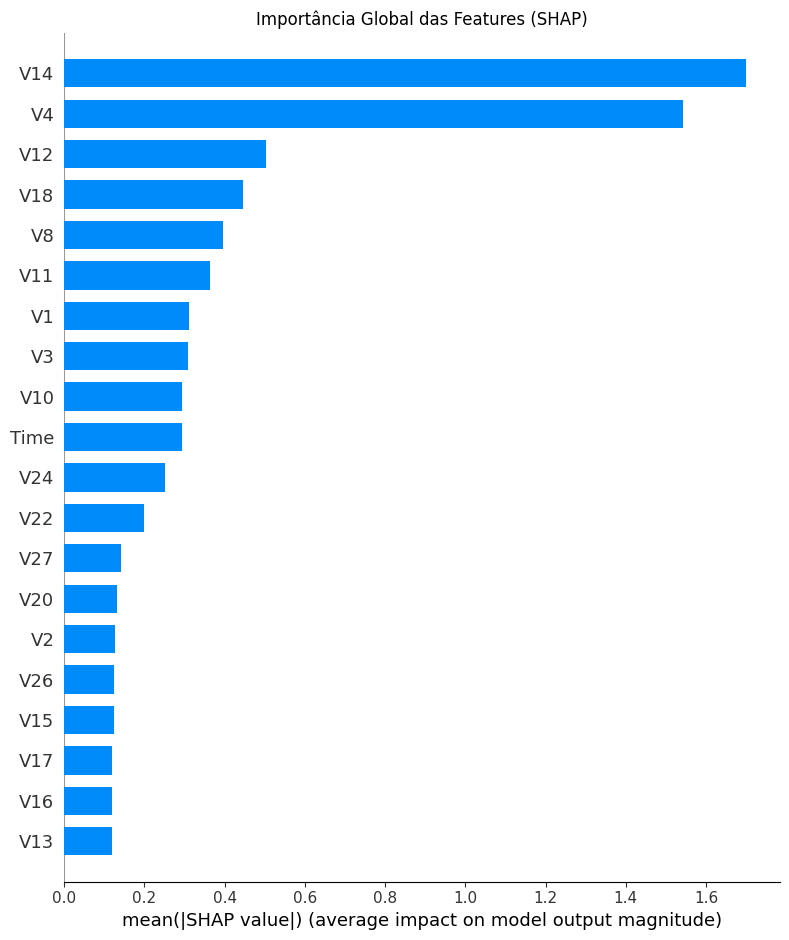

--- Gráfico de Impacto das Features por Valor (SHAP) ---


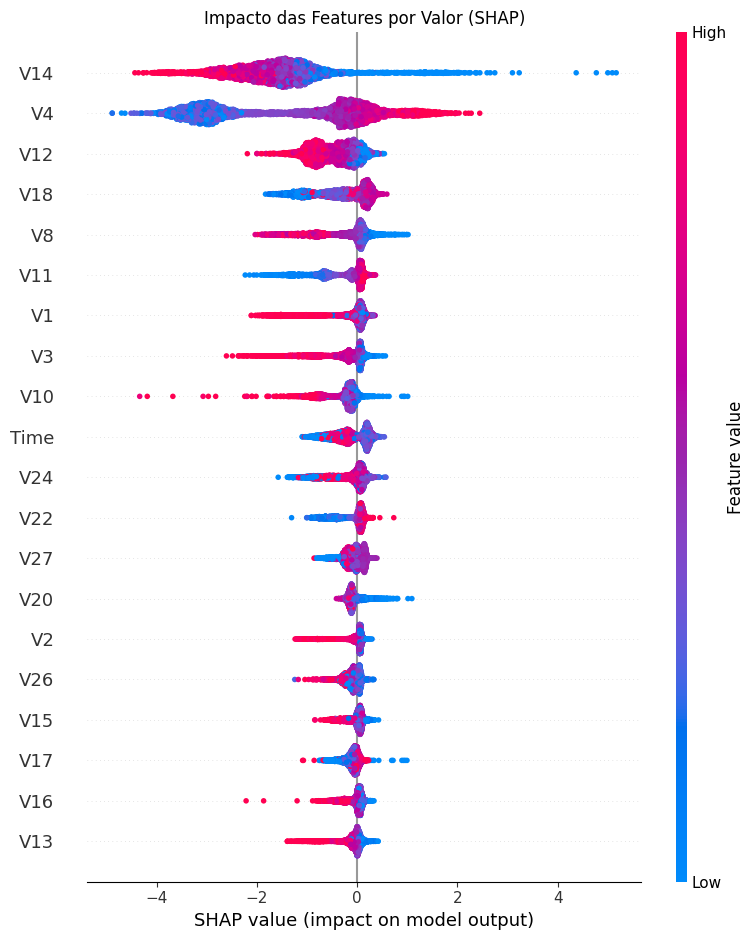

In [20]:
import shap
import matplotlib.pyplot as plt # Garante que plt está importado, caso contrário os plots não aparecem

# 1. Escolher o modelo para o SHAP (XGBoost treinado com SMOTE)
explainer = shap.TreeExplainer(xgb_clf)

# 2. Calcular os valores SHAP (amostra de 5000)
X_test_sample = X_test.sample(n=5000, random_state=42) 
shap_values = explainer.shap_values(X_test_sample)

# **--- NOVO BLOCO DE LÓGICA DE INDEXAÇÃO ---**

# Verifica se o SHAP retornou uma lista de arrays (problema de classificação binária)
if isinstance(shap_values, list):
    # Para classificação binária, o índice 1 corresponde à classe positiva (Fraude)
    shap_values_to_plot = shap_values[1] 
else:
    # Se retornou um único array, usamos diretamente
    shap_values_to_plot = shap_values

# **--- FIM DO BLOCO DE LÓGICA DE INDEXAÇÃO ---**

# 3. Visualizar a Importância Global das Features (Summary Plot - Barras)
print("--- Gráfico de Importância Global das Features (SHAP) ---")
shap.summary_plot(
    shap_values_to_plot,
    X_test_sample,
    plot_type="bar",
    show=False
)
plt.title('Importância Global das Features (SHAP)')
plt.tight_layout() # Ajuda a evitar cortes no plot
plt.show()

# 4. Visualizar o impacto e a direção de cada feature (Dots)
print("--- Gráfico de Impacto das Features por Valor (SHAP) ---")
shap.summary_plot(
    shap_values_to_plot, 
    X_test_sample,
    show=False
)
plt.title('Impacto das Features por Valor (SHAP)')
plt.tight_layout()
plt.show()


## Fase 6: Implantação e Comunicação (Output para Power BI)

### 6.1: Preparação do Dataset de Comunicação

| Etapa | Justificativa | Output |
| :--- | :--- | :--- |
| **Exportação Unificada** | Para mover o projeto da análise de código para a comunicação de resultados, todos os dados de teste (`X_test`), previsões e valores SHAP precisam ser consolidados. | Um único arquivo CSV (`fraude_analise_final_pbi.csv`) contendo a *feature* de entrada, a classe real, a previsão do modelo e o valor SHAP (contribuição) de cada *feature*. |
| **Dashboard Power BI** | Este CSV é o *input* para a construção de um dashboard interativo (Power BI/Tableau)  que irá apresentar o **Desempenho** (Matriz de Confusão, KPIs) e a **Interpretabilidade (XAI)** do modelo aos stakeholders de risco. | Demonstra a capacidade de traduzir resultados técnicos em *insights* de negócio e *storytelling* de dados. |

In [21]:
import pandas as pd
import numpy as np
import shap

# --- Geração dos Valores SHAP Finais ---
# Recalculamos os SHAP values, mas agora para todo o conjunto de teste para ter dados completos no PBI.
# O conjunto de teste é X_test.

explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test) 

# Para classificação binária, usamos a lista de valores SHAP da classe positiva (Fraude: índice 1)
if isinstance(shap_values, list):
    shap_values_final = shap_values[1]
else:
    shap_values_final = shap_values

# 1. Criação do DataFrame de Resultados
# X_test é o nosso conjunto de features.
results_df = X_test.copy()

# 2. Adição da Classe Real e da Previsão do Modelo
results_df['True_Class'] = y_test
results_df['Predicted_Class'] = y_pred_xgb_smote 

# 3. Adição das Previsões de Probabilidade
results_df['Predicted_Proba'] = xgb_clf.predict_proba(X_test)[:, 1]

# 4. Adição dos Valores SHAP: Criamos novas colunas (SHAP_V1, SHAP_V2, etc.)
# Convertemos os SHAP values para um DataFrame
shap_df = pd.DataFrame(shap_values_final, columns=[f'SHAP_{col}' for col in X_test.columns], index=results_df.index)

# Juntar os DataFrames
final_output_df = pd.concat([results_df, shap_df], axis=1)

# 5. Exportar para CSV
output_path = 'fraude_analise_final_pbi.csv'
final_output_df.to_csv(output_path, index=True) 

print(f"\n✅ Exportação concluída! Arquivo salvo em: {output_path}")
print(f"O DataFrame final tem {final_output_df.shape[0]} linhas e {final_output_df.shape[1]} colunas.")
print("Este arquivo CSV contém todas as informações necessárias para a criação do Dashboard Power BI.")


✅ Exportação concluída! Arquivo salvo em: fraude_analise_final_pbi.csv
O DataFrame final tem 56962 linhas e 63 colunas.
Este arquivo CSV contém todas as informações necessárias para a criação do Dashboard Power BI.


Estrutura do Dashboard no Power BI
Com o arquivo fraude_analise_final_pbi.csv, você pode criar três páginas principais no seu relatório Power BI, conforme planejamos:

1. Desempenho do Modelo (KPIs de Negócio)
KPIs: Cartões mostrando Recall, Precision e F1-Score finais.

Visualização Principal: Uma Matriz de Confusão (customizada com DAX ou visual nativo) com os números de TP, FP, FN, TN.

Impacto Financeiro: Simulação de Fraude Evitada (Economia) (baseada em TP * Valor Médio de Fraude) versus Custo de Falsos Positivos (baseada em FP * Custo por Bloqueio).

2. Interpretabilidade (XAI)
Importância Global: Um gráfico de barras simples (utilizando as colunas SHAP_V1 a SHAP_Amount) para replicar a importância das features (V14, V4, V12, etc.).

Análise de Casos: Uma tabela de Falsos Negativos (FN) (onde True_Class = 1 e Predicted_Class = 0) para que a equipe de risco possa investigar quais fraudes o modelo perdeu e por quê (usando os valores SHAP dessa transação).

3. Análise dos Dados (EDA)
Gráficos da Fase 1 (EDA), como o Boxplot de Amount por Class e o gráfico de desbalanceamento.